In [908]:
import numpy as np
import random
from copy import deepcopy
from utils import *
from scipy.ndimage.filters import gaussian_filter, maximum_filter, convolve
from os.path import join
from shutil import copyfile


In [909]:
def plot_one_slice(array_3d, dim, idx, vmin=0, vmax=255):
    plt.figure(dpi=200)
    if dim=='x':  # shape of array_3d should be z,x,y
        plt.imshow(array_3d[:,idx,:], cmap='Greys', vmin=vmin, vmax=vmax)
    elif dim=='y':
        plt.imshow(array_3d[:,:,idx], cmap='Greys', vmin=vmin, vmax=vmax)
    elif dim=='z':
#         array_3d[array_3d<118]=0
        plt.imshow(array_3d[idx,:,:], cmap='Greys', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

def plot_merged_slices(array_3d, dim, idx0, idx1, title=None, vmin=0, vmax=255):
    plt.figure(dpi=200)
    if dim=='x':  # shape of array_3d should be z,x,y
        to_show=np.max(array_3d[:,idx0:idx1,:], axis=1)
        plt.imshow(to_show, cmap='Greys', vmin=vmin, vmax=vmax)  # aspect=2
    elif dim=='y':
        plt.imshow(np.max(array_3d[:,:,idx0:idx1], axis=2), cmap='Greys', vmin=vmin, vmax=vmax)
    elif dim=='z':
#         array_3d[array_3d<118]=0
        plt.imshow(np.max(array_3d[idx0:idx1,:,:], axis=0), cmap='Greys', vmin=vmin, vmax=vmax)
    plt.colorbar()
    
    if title is not None:
        plt.title(title)
    plt.show()

In [910]:
ROOT_NOISE_LOWER = 0.9  # 0.8
ROOT_NOISE_UPPER = 1.1  # 1.2
MIN_RANDOM_UNIFORM_NOISE = -0.05
MAX_RANDOM_UNIFORM_NOISE = 0.05

def normalize_to(arr, min_value, max_value):
    arr = arr.astype(np.float32)
    arr -= arr.min()
    arr /= (arr.max() - arr.min())
    arr *= (max_value - min_value)
    arr += min_value
    return arr


def add_noise_to_root_crop(cropped_occupancy, cropped_intensity):
#     if IF_ADD_VOIDS:
#         # with some probability, clear a small part of root part to mimic the voids in images
#         dice2 = np.random.uniform()
#         if dice2 < CHANCE_MIMIC_ROOT_VOID:  # 50% chance
#             thickness_void = np.random.randint(2, high=4)
#             void_start = np.random.randint(cropped_occupancy.shape[0] - thickness_void + 1)
#             cropped_occupancy[void_start:void_start + thickness_void] = 0

#             # add periodically disconnected planes
#             # thickness_disconnection = np.random.randint(2, high=5)  # the thickness can be either 2,3, or 4
#             # thickness_connected = np.random.randint(2,
#             #                                         high=5)  # the thickness of connected part, can be 2,3,4
#             # z_coord = np.arange(cropped_occupancy.shape[0])
#             # # make zebra-like pattern
#             # cropped_occupancy[z_coord % (thickness_disconnection + thickness_connected)
#             #                   < thickness_disconnection] = 0

    # use gaussian filter to blur the root intensity 
    
    # add some simple noise (random normal) to the root intensity grid
    random_noise = np.random.normal(0, scale=1, size=cropped_intensity.shape)
    # if len(random_noise) == 0:
    #     print("%%%%%%%%%%%%%%%%% cropped intensity shape:", cropped_intensity.shape)
    #     print('intensity shape:', intensity.shape)
    #     print('z_i_start, x_i_start, y_i_start:', z_i_start, x_i_start, y_i_start)
    random_noise = normalize_to(random_noise, ROOT_NOISE_LOWER, ROOT_NOISE_UPPER)
    cropped_intensity = cropped_intensity.astype(np.float32)
    noised_intensity = cropped_intensity * random_noise

    # add random uniform noise to the root intensity
    ru_noise = np.random.uniform(MIN_RANDOM_UNIFORM_NOISE, MAX_RANDOM_UNIFORM_NOISE, size=cropped_intensity.shape)
    noised_intensity = noised_intensity + cropped_intensity*ru_noise
    # noised_intensity = np.clip(noised_intensity, 0, 255)  # clip in the range of uint8

    noised_intensity[cropped_occupancy == 0] = 0
    return noised_intensity, cropped_intensity, cropped_occupancy


def combine_whole_intensity_with_soil(intensity, occupancy, pure_soil, apply_soil_power=False, out_of_pot_mask=None, soil_surface_to_remove=5):
    '''

    :param intensity:
    :param occupancy:
    :param pure_soil:
    # :param soil_scaling_factor:
    :param out_of_pot_mask:
    :return:
    '''
    # remove the top and bottom area of the soil, because they are empty
    pure_soil = pure_soil[soil_surface_to_remove:-soil_surface_to_remove,:,:,:]
    
    # convert to float datatype
    intensity = intensity.astype(np.float32)
    occupancy = occupancy.astype(np.float32)
    pure_soil = pure_soil.astype(np.float32)
    
    # normalize to (0,255)
    intensity = normalize_to(intensity, 0, 255)
    occupancy = normalize_to(occupancy, 0, 255)
    pure_soil = normalize_to(pure_soil, 0, 255)
    
    # blur the intensity and occupancy a little bit
    intensity = gaussian_filter(intensity, sigma=0.4)
    occupancy = gaussian_filter(occupancy, sigma=0.4)
    
    # the shape should be in the order of (z, _, x, y)
    assert len(intensity.shape) == 4
    assert len(pure_soil.shape) == 4
    intensity_z, _, intensity_x, intensity_y = intensity.shape
    soil_z, _, soil_x, soil_y = pure_soil.shape

    # match the shape of pure soil data to the intensity grid
    if intensity_x > soil_x:
        diff_x = intensity_x - soil_x
        # 'wrap' mode to make the padded area similar to the original noise data
        pure_soil = np.pad(pure_soil, pad_width=((0, 0), (0, 0), (diff_x // 2, diff_x - diff_x // 2), (0, 0)),
                           mode='wrap')
    elif intensity_x < soil_x:
        diff_x = soil_x - intensity_x
        pure_soil = pure_soil[:, :, diff_x // 2:-(diff_x - diff_x // 2), :]

    if intensity_y > soil_y:
        diff_y = intensity_y - soil_y
        pure_soil = np.pad(pure_soil, pad_width=((0, 0), (0, 0), (0, 0), (diff_y // 2, diff_y - diff_y // 2)),
                           mode='wrap')
    elif intensity_y < soil_y:
        diff_y = soil_y - intensity_y
        pure_soil = pure_soil[:, :, :, diff_y // 2:-(diff_y - diff_y // 2)]

    if intensity_z > soil_z:
        # extend the z dimension of pure soil data by repeating z
        num_whole_repeats = intensity_z // soil_z
        depth_last_partial_repeat = intensity_z % soil_z
        if num_whole_repeats > 1:
            pure_soil = np.concatenate([pure_soil for _ in range(num_whole_repeats)], axis=0)
        if depth_last_partial_repeat > 0:
            pure_soil = np.concatenate((pure_soil, pure_soil[:depth_last_partial_repeat, :, :]), axis=0)
    elif intensity_z < soil_z:
        diff_z = soil_z - intensity_z
        pure_soil = pure_soil[diff_z // 2:-(diff_z - diff_z // 2), :, :, :]

    # # debugging
    # print('final intensity shape:', intensity.shape)
    # print('final soil shape:', pure_soil.shape)

    # pure_soil = (pure_soil * soil_scaling_factor).astype(np.uint8)
    
    # use soil power to adjust the relative intensity of soil
    if apply_soil_power:
        pure_soil = normalize_to(pure_soil, 0, 1)
#         soil_power = np.exp(-0.7 + 1.4 * np.random.rand(1))
        soil_power = 1  # no augmentation 
        print('soil_power:', soil_power)
        pure_soil = np.power(pure_soil, soil_power)
        pure_soil = normalize_to(pure_soil, 0, 255)

    # combine the intensity crop and the soil crop
    combined = np.zeros(pure_soil.shape) + pure_soil

    # combined[intensity > 0] = 0
    # to make the border between root and soil softer:
#     alpha = 0.7 + 0.3 * np.random.rand(1)  # using Nils method here, alpha is the ratio of blending root and soil
    alpha = 0.75  # no augmentation 
    print('alpha:', alpha)
    combined = combined * (1 - occupancy / 255. * alpha)

    # random_noise = np.random.randint(MIN_RANDOM_UNIFORM_NOISE, high=MAX_RANDOM_UNIFORM_NOISE,
    #                                  size=intensity.shape)
    # noised_intensity = intensity + random_noise
    # # noised_intensity = np.clip(noised_intensity, 0, 255)  # clip in the range of uint8
    # noised_intensity[intensity == 0] = 0

    # add noise to root
    noised_intensity, intensity, occupancy = add_noise_to_root_crop(occupancy, intensity)

    # if IF_AUGMENT_ROOT:
    #     dice = np.random.uniform()
    #     if dice < 0.5:  # 50% chance of making continuous slices
    #         thickness_disconnection = np.random.randint(2, high=5)  # the thickness can be either 2,3, or 4
    #         thickness_connected = np.random.randint(2, high=5)  # the thickness of connected part, can be 2,3,4
    #         z_coord = np.arange(noised_intensity.shape[0])
    #         mult_factor = np.random.uniform()  # multiply with random number in range (0,1)
    #         noised_intensity = noised_intensity.astype(np.float32)
    #         noised_intensity[z_coord % (thickness_disconnection + thickness_connected)
    #                          < thickness_disconnection] *= mult_factor

#     root_brightness = 0.8 + 0.5 * np.random.rand(1)  # using Nils method here
    root_brightness = 1  # no augmentation 
    print('root_brightness:', root_brightness)
    combined += noised_intensity * alpha * root_brightness

    # imitate pot, set the area out of the pot mask to 0
    if out_of_pot_mask is not None:
        assert intensity.shape == out_of_pot_mask.shape
        # if some root intensity goes out of pot, then do not apply pot mask
        if (intensity > 0).sum() > 0:
            intensity_out_of_pot_perc = (intensity[out_of_pot_mask.astype(bool)] > 0).sum() \
                                        / (intensity > 0).sum()
            if intensity_out_of_pot_perc > 0:
                out_of_pot_mask *= 0
        combined[out_of_pot_mask.astype(bool)] = 0

    # # debugging
    # print('combined shape:', combined.shape)
    
    # blur the combined image a little bit
    combined = gaussian_filter(combined, sigma=0.4)
    
    # random scaling
#     random_factor = 0.2 + 1.2 * np.random.rand(1)  # using Nils method here
    random_factor = 0.8  # no augmentation 
    print('random scaling factor:', random_factor)
    combined *= random_factor

    return combined


def randomly_augment_volume(volume, x_flip=None, y_flip=None, xy_swap=None):
    assert len(volume.shape) == 4  # should be the shape of (z,1,x,y)
    if x_flip is not None:
        x_flip = random.choice([0, 1])
    if y_flip is not None:
        y_flip = random.choice([0, 1])
    if xy_swap is not None:
        xy_swap = random.choice([0, 1])
    
    if x_flip != 0:
        volume = np.flip(volume, axis=2)
    if y_flip != 0:
        volume = np.flip(volume, axis=3)
    if xy_swap != 0:
        volume = np.swapaxes(volume, 2, 3)

    return volume, x_flip, y_flip, xy_swap
    

    

In [911]:
# root_filename_list1 = ['random_virtual_roots/diff_time_points/845361/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/diff_time_points/903007/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/diff_time_points/imitate_lupine22/39882/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/diff_time_points/imitate_lupine22/479497/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/diff_time_points/imitate_lupineSmall/110841/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/diff_time_points/imitate_lupineSmall/804383/stopTime100.00%/occupancy_small_alias_256x256x200.npy',
#                      ]

# root_filename_list2 = ['random_virtual_roots/100912/occupancy_small_alias_256x256x200.npy',
# 'random_virtual_roots/125996/occupancy_small_alias_256x256x200.npy',
# 'random_virtual_roots/164793/occupancy_small_alias_256x256x200.npy',
# 'random_virtual_roots/281419/occupancy_small_alias_256x256x200.npy',
# 'random_virtual_roots/432101/occupancy_small_alias_256x256x200.npy',
# 'random_virtual_roots/532545/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/588744/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/610538/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/654914/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/776154/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/86313/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/934775/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/948413/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupine22/23721/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupine22/431808/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupine22/631573/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupine22/705339/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupineSmall/136261/occupancy_small_alias_256x256x200.npy',
#        'random_virtual_roots/imitate_lupineSmall/483360/occupancy_small_alias_256x256x200.npy']

# real_soil_file_list = ['sand_d1_70x1x256x256_uint8.npy', 'sand_unsat_0.39%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.23%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.18%wc_70x1x256x256_uint8.npy', 'sand_d2_70x1x256x256_uint8.npy', 'sand_sat_0.43%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.27%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.34%wc_70x1x256x256_uint8.npy']


In [922]:
# root_filename_list1.remove(root_filename_list1[0])
# root_filename_list1

[]

In [923]:
# root_filename_list2.remove(root_filename_list2[0])
# root_filename_list2

In [924]:
# choose one root data that's left, and combine with a randomly chosen soil data
soil_data_path = join('/home/user/zhaoy/local_dir/data/pure_soil/real_soil_noise', np.random.choice(real_soil_file_list))
current_root_name = root_filename_list1[0]
root_data_path = join('/home/user/zhaoy/local_dir/data', current_root_name)
gt_path_1x = join('/home/user/zhaoy/local_dir/data', join('/'.join(current_root_name.split('/')[:-1]), 'occupancy_small_antialias_256x256x200.npy'))
gt_path_2x = join('/home/user/zhaoy/local_dir/data', join('/'.join(current_root_name.split('/')[:-1]), 'ground_truth_res_2x.npy'))
print('soil_data_path:', soil_data_path)
print('root_data_path:', root_data_path)
print('gt_path_1x:', gt_path_1x)
print('gt_path_2x:', gt_path_2x)


IndexError: list index out of range

In [915]:

# soil_data_path = '/home/user/zhaoy/local_dir/data/pure_soil/real_soil_noise/sand_d2_70x1x256x256_uint8.npy'
# root_data_path = '/home/user/zhaoy/local_dir/data/random_virtual_roots/diff_time_points/845361/stopTime73.61%/occupancy_small_alias_256x256x200.npy'

soil_img = np.load(soil_data_path)
print('shape of soil:', soil_img.shape)
print('max of soil:', soil_img.max())

soil_img, _, _, _ = randomly_augment_volume(soil_img)
intensity = np.load(root_data_path)
intensity = np.expand_dims(intensity, 1)
print('shape of intensity:', intensity.shape)
print('max of intensity:', intensity.max())
print()

intensity, x_flip0, y_flip0, xy_swap0 = randomly_augment_volume(intensity)
occupancy = deepcopy(intensity)

gt_1x = np.expand_dims(np.load(gt_path_1x), 1)
gt_2x = np.expand_dims(np.load(gt_path_2x), 1)
gt_1x, _, _, _ = randomly_augment_volume(gt_1x, x_flip=x_flip0, y_flip=y_flip0, xy_swap=xy_swap0)
gt_2x, _, _, _ = randomly_augment_volume(gt_2x, x_flip=x_flip0, y_flip=y_flip0, xy_swap=xy_swap0)
gt_1x = np.squeeze(gt_1x)
gt_2x = np.squeeze(gt_2x)

combined = combine_whole_intensity_with_soil(intensity, occupancy, soil_img, apply_soil_power=True, out_of_pot_mask=None, soil_surface_to_remove=6)

if combined.max()>255:  # normalize to the range of (0,255) if the max value is over 255
    combined = normalize_to(combined, 0, 255)
    

shape of soil: (70, 1, 256, 256)
max of soil: 255
shape of intensity: (200, 1, 256, 256)
max of intensity: 255

soil_power: 1
alpha: 0.75
root_brightness: 1
random scaling factor: 0.8


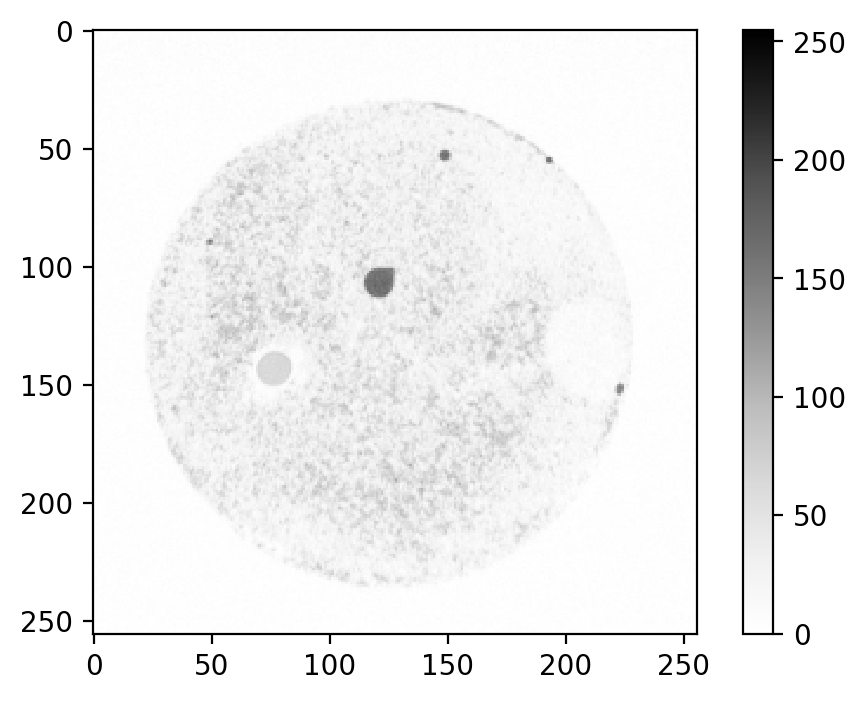

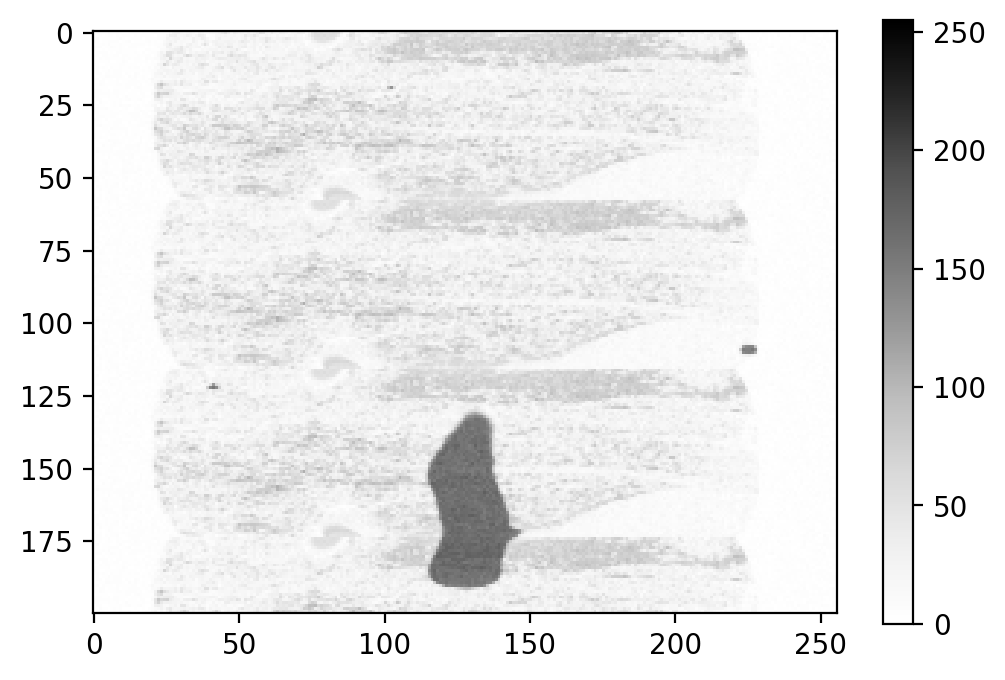

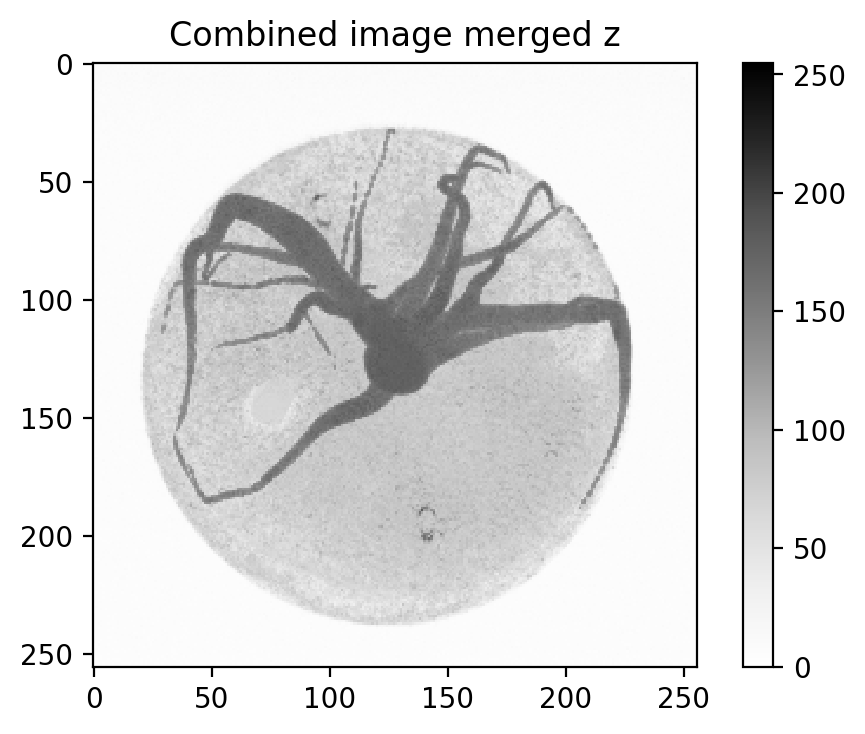

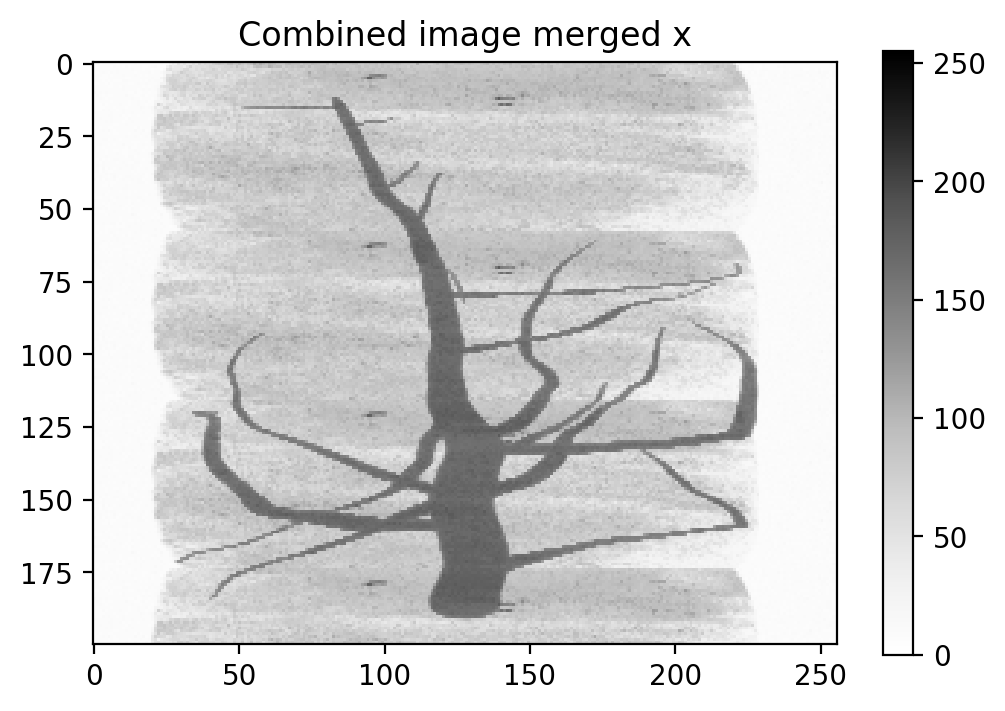

In [916]:
combined_squeezed = np.squeeze(combined)
plot_one_slice(combined_squeezed, 'z', combined_squeezed.shape[0]//2)
plot_one_slice(combined_squeezed, 'x', combined_squeezed.shape[1]//2)

plot_merged_slices(combined_squeezed, 'z', 0, combined_squeezed.shape[0], title='Combined image merged z')
plot_merged_slices(combined_squeezed, 'x', 0, combined_squeezed.shape[1], title='Combined image merged x')

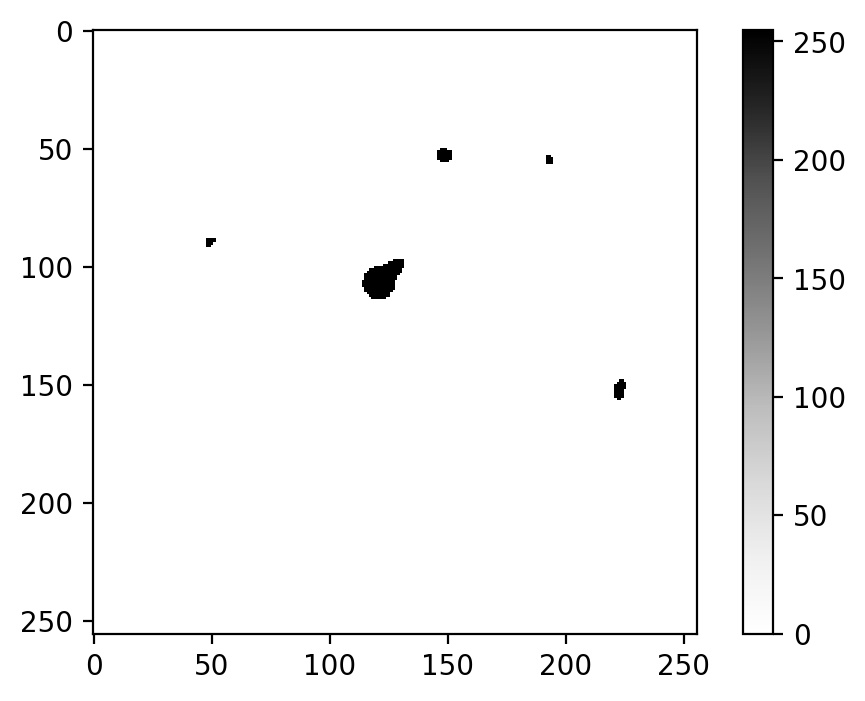

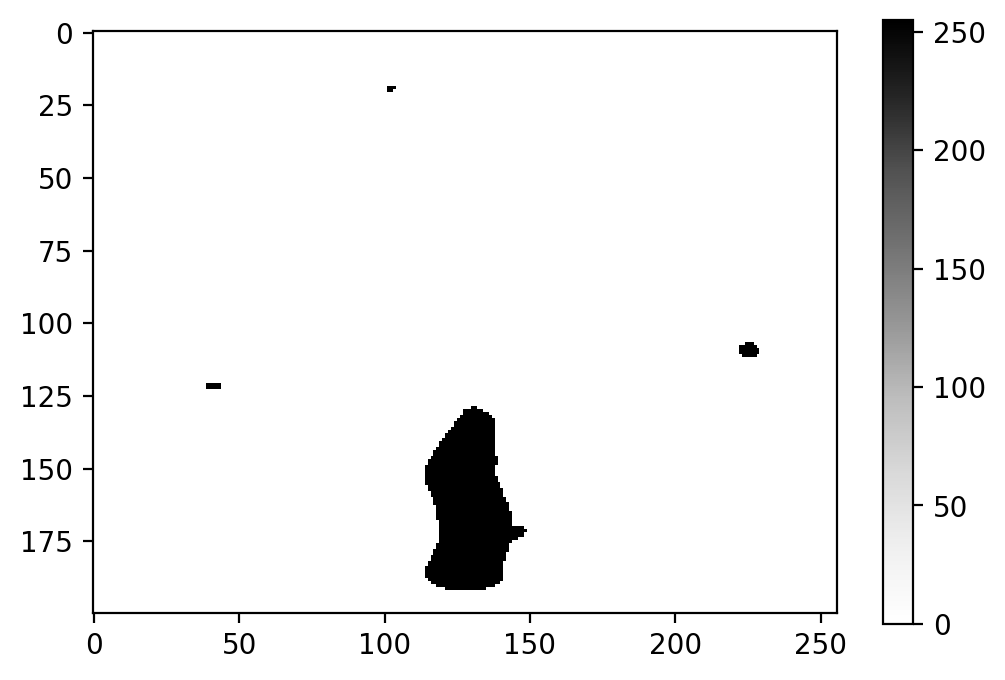

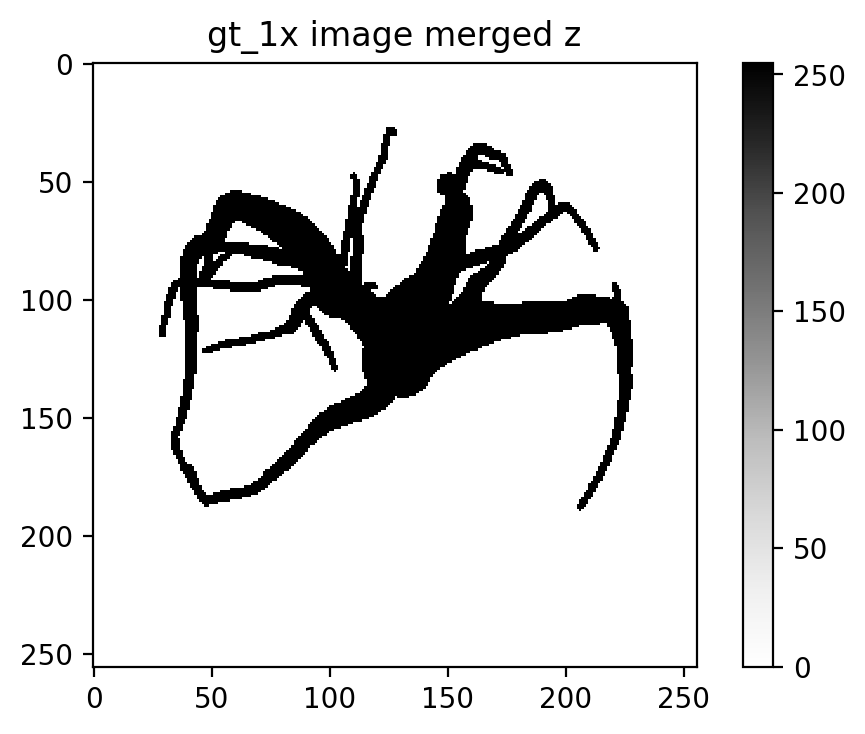

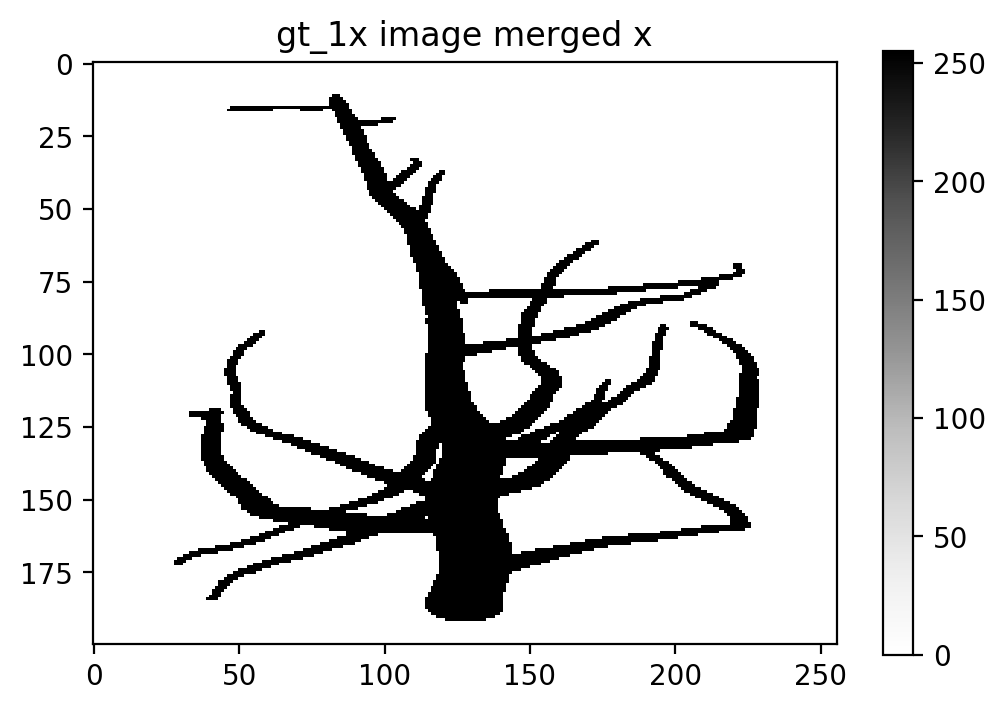

In [917]:
plot_one_slice(gt_1x, 'z', gt_1x.shape[0]//2)
plot_one_slice(gt_1x, 'x', gt_1x.shape[1]//2)

plot_merged_slices(gt_1x, 'z', 0, gt_1x.shape[0], title='gt_1x image merged z')
plot_merged_slices(gt_1x, 'x', 0, gt_1x.shape[1], title='gt_1x image merged x')

In [918]:
print(combined.shape)
print(combined.max())

(200, 1, 256, 256)
184.4713583825286


### Save the combined image to file

In [919]:

def combine_root_soil_filenames(root_data_path, soil_data_path):
#     print(len(root_data_path.strip('/').split('/')))
#     print(root_data_path.strip('/').split('/'))
    
    s0 = '_'.join(soil_data_path.strip('/').split('/')[-1].split('_')[:-2])
    if len(root_data_path.strip('/').split('/'))==10:
        # '/home/user/zhaoy/local_dir/data/random_virtual_roots/diff_time_points/845361/stopTime73.61%/occupancy_small_alias_256x256x200.npy'
        s_list = root_data_path.strip('/').split('/')
        s1, s2, s3 = s_list[-4], s_list[-3], s_list[-1] 
        s3 = s3.split('.')[0].split('_')[-1]
        
        # print(s1, s2, s3, s0)
        return  '_'.join([s0, s1, s2, s3]) + '.npy'
         
    elif len(root_data_path.strip('/').split('/'))==11:
        # '/home/user/zhaoy/local_dir/data/random_virtual_roots/imitate_lupine22/39882/stopTime84.55%/occupancy_small_alias_256x256x200.npy'
        s_list = root_data_path.strip('/').split('/')
        s1, s2, s3, s4 = s_list[-5], s_list[-4], s_list[-3], s_list[-1] 
        s4 = s4.split('.')[0].split('_')[-1]   

        # print(s1, s2, s3, s4, s0)
        return  '_'.join([s0, s1, s2, s3, s4]) + '.npy'
    
    elif len(root_data_path.strip('/').split('/'))==8:
        # '/home/user/zhaoy/local_dir/data/random_virtual_roots/100912/occupancy_small_alias_256x256x200.npy'
        s_list = root_data_path.strip('/').split('/')
        s1, s2 = s_list[-2], s_list[-1] 
        s2 = s2.split('.')[0].split('_')[-1]
        # print(s1, s2, s0)
        return '_'.join([s0, s1, s2]) + '.npy'

    elif len(root_data_path.strip('/').split('/'))==9:
        # '/home/user/zhaoy/local_dir/data/random_virtual_roots/imitate_lupine22/23721/occupancy_small_alias_256x256x200.npy'
        s_list = root_data_path.strip('/').split('/')
        s1, s2, s3 = s_list[-3], s_list[-2], s_list[-1] 
        s3 = s3.split('.')[0].split('_')[-1]
        # print(s1, s2, s3, s0)
        return '_'.join([s0, s1, s2, s3]) + '.npy'

    else:
        print('Warning: unknown root_data_path')
        return

# root_data_path1 = '/home/user/zhaoy/local_dir/data/random_virtual_roots/100912/occupancy_small_alias_256x256x200.npy'
# root_data_path1 = '/home/user/zhaoy/local_dir/data/random_virtual_roots/diff_time_points/845361/stopTime73.61%/occupancy_small_alias_256x256x200.npy'
# root_data_path1 = '/home/user/zhaoy/local_dir/data/random_virtual_roots/imitate_lupine22/23721/occupancy_small_alias_256x256x200.npy'
# soil_data_path1 = 'sand_d1_70x1x256x256_uint8.npy'
# soil_data_path1 = 'sand_unsat_0.23%wc_70x1x256x256_uint8.npy'

# print(root_data_path)
print(combine_root_soil_filenames(root_data_path, soil_data_path))

path_to_save = '/home/user/zhaoy/local_dir/data/test_data/virtual_data/' + combine_root_soil_filenames(root_data_path, soil_data_path)
# np.save(path_to_save, combined.astype(np.uint8))


sand_unsat_0.18%wc_diff_time_points_imitate_lupineSmall_804383_256x256x200.npy


### Save the gt at the same time with the same naming rule

In [920]:
print(gt_1x.dtype)
print(gt_1x.shape)
print(gt_1x.max())

print(gt_2x.dtype)
print(gt_2x.shape)
print(gt_2x.max())

uint8
(200, 256, 256)
255
uint8
(400, 512, 512)
255


In [921]:
gt_1x_path_to_save = '/home/user/zhaoy/local_dir/data/test_data/virtual_data/ground_truth/gt_1x' + combine_root_soil_filenames(root_data_path, '')
print('gt_1x_path_to_save:', gt_1x_path_to_save)
gt_2x_path_to_save = '/home/user/zhaoy/local_dir/data/test_data/virtual_data/ground_truth/gt_2x' + combine_root_soil_filenames(root_data_path, '')
print('gt_2x_path_to_save:', gt_2x_path_to_save)

# np.save(gt_1x_path_to_save, gt_1x.astype(np.uint8))
# np.save(gt_2x_path_to_save, gt_2x.astype(np.uint8))

### copy the gt to the target folder  
# NO, copying file is not sufficient! Because there are augmentations of the root
# copyfile(gt_path_1x, gt_1x_path_to_save)
# copyfile(gt_path_2x, gt_2x_path_to_save)


gt_1x_path_to_save: /home/user/zhaoy/local_dir/data/test_data/virtual_data/ground_truth/gt_1x_diff_time_points_imitate_lupineSmall_804383_256x256x200.npy
gt_2x_path_to_save: /home/user/zhaoy/local_dir/data/test_data/virtual_data/ground_truth/gt_2x_diff_time_points_imitate_lupineSmall_804383_256x256x200.npy


In [ ]:
path_to_save

In [588]:
# ### check how to augment the gt to match the combined data:
# gt_path = gt_2x_path_to_save  # gt_2x_path_to_save
# gt = np.load(gt_path)
# print('gt shape:', gt.shape)
# # gt = np.swapaxes(gt, 1, 2)
# gt = np.flip(gt, 1)  # flip x
# # gt = np.flip(gt, 2)  # flip y
# np.save('/home/user/zhaoy/local_dir/data/test_data/virtual_data/ground_truth/gt_2x_imitate_lupineSmall_483360_256x256x200_xf.npy',gt)


gt shape: (400, 512, 512)


255
0
(200, 1, 256, 256)
uint8


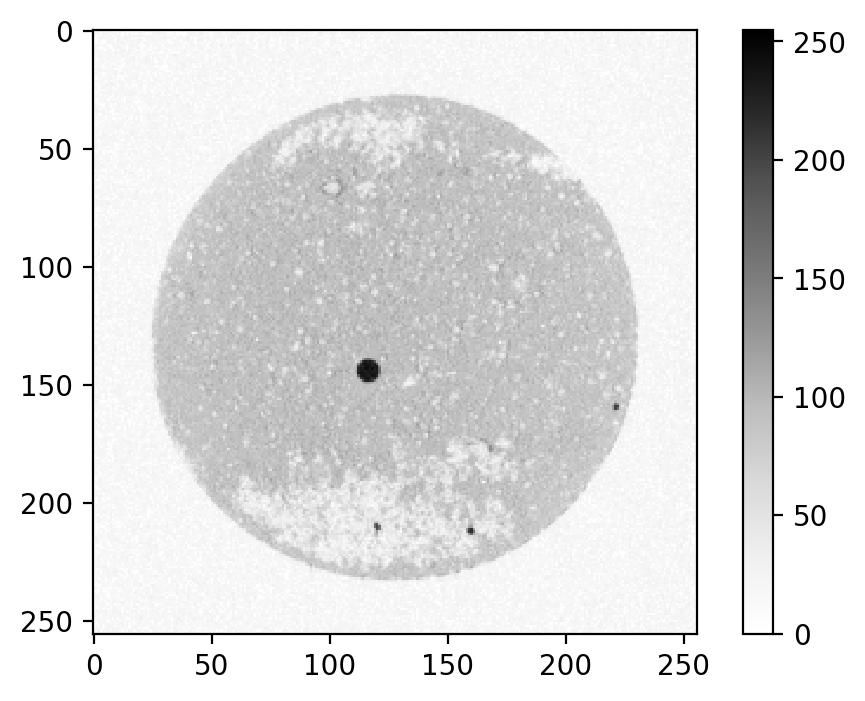

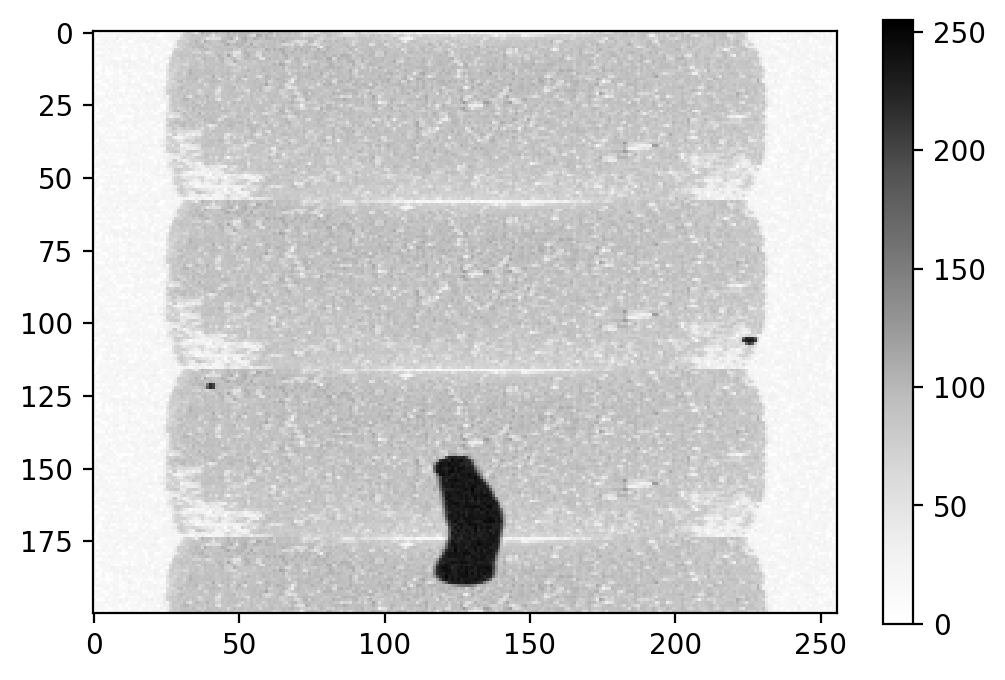

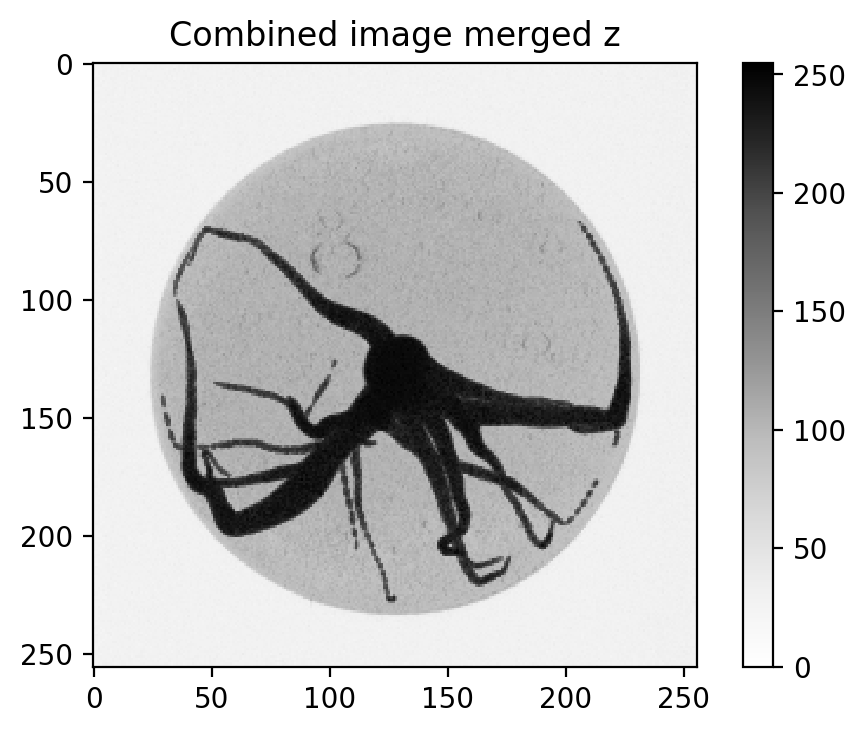

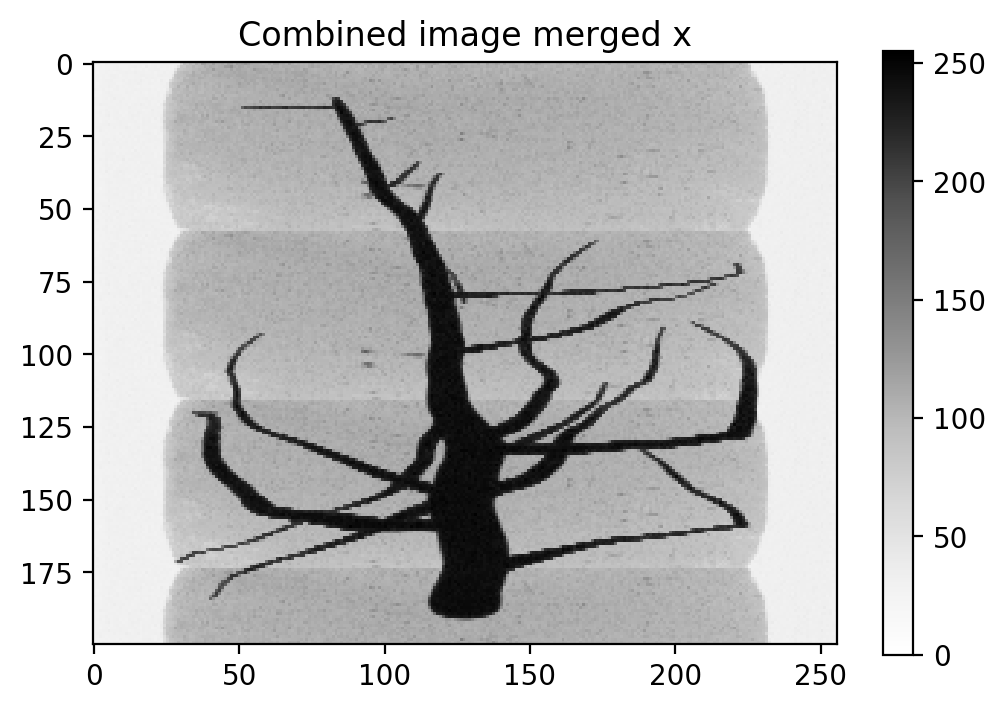

In [439]:
# check if saved correctly
saved = np.load(path_to_save)
print(saved.max())
print(saved.min())
print(saved.shape)
print(saved.dtype)

saved_squeezed = np.squeeze(saved)
plot_one_slice(saved_squeezed, 'z', 70)
plot_one_slice(saved_squeezed, 'x', 120)

plot_merged_slices(saved_squeezed, 'z', 0, 199, title='Combined image merged z')
plot_merged_slices(saved_squeezed, 'x', 0, 255, title='Combined image merged x')

# <font color='red'>Val root data</font>
### random_virtual_roots diff time points:
'random_virtual_roots/diff_time_points/845361/stopTime73.61%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/903007/stopTime75.85%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupine22/39882/stopTime84.55%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupine22/479497/stopTime75.47%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupineSmall/110841/stopTime82.47%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupineSmall/804383/stopTime82.87%/occupancy_small_alias_256x256x200.npy'

### random_virtual_roots main:
'random_virtual_roots/100912/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/125996/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/164793/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/281419/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/432101/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/532545/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/588744/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/610538/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/654914/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/776154/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/86313/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/934775/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/948413/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/23721/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/431808/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/631573/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/705339/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupineSmall/136261/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupineSmall/483360/occupancy_small_alias_256x256x200.npy'
       
### Oguz dataset (datalist):
/home/user/zhaoy/root_mri/data/datalists_for_model_training/20190717_oguz_datasets_non_combining_noTrain_visReal/dataset.npz

# <font color='red'>Real soil data</font>
### /home/user/zhaoy/local_dir/data/pure_soil/real_soil_noise:
'sand_d1_70x1x256x256_uint8.npy', 'sand_unsat_0.39%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.23%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.18%wc_70x1x256x256_uint8.npy', 'sand_d2_70x1x256x256_uint8.npy', 'sand_sat_0.43%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.27%wc_70x1x256x256_uint8.npy', 'sand_unsat_0.34%wc_70x1x256x256_uint8.npy'

### Datalist: /home/user/zhaoy/root_mri/data/datalists_for_model_training/20190423_pure_soil_only
#### Train:
34%wc_70x1x256x256_uint8.npy,  39%wc_70x1x256x256_uint8.npy,  43%wc_70x1x256x256_uint8.npy, sand_d1_70x1x256x256_uint8.npy
#### Val:
sand_d2_70x1x256x256_uint8.npy


In [ ]:
root_filename_list1 = ['random_virtual_roots/diff_time_points/845361/stopTime73.61%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/903007/stopTime75.85%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupine22/39882/stopTime84.55%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupine22/479497/stopTime75.47%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupineSmall/110841/stopTime82.47%/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/diff_time_points/imitate_lupineSmall/804383/stopTime82.87%/occupancy_small_alias_256x256x200.npy',
                     ]

root_filename_list2 = ['random_virtual_roots/100912/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/125996/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/164793/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/281419/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/432101/occupancy_small_alias_256x256x200.npy',
'random_virtual_roots/532545/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/588744/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/610538/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/654914/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/776154/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/86313/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/934775/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/948413/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/23721/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/431808/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/631573/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupine22/705339/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupineSmall/136261/occupancy_small_alias_256x256x200.npy',
       'random_virtual_roots/imitate_lupineSmall/483360/occupancy_small_alias_256x256x200.npy']

In [137]:
combined.max()

129.46625175373222

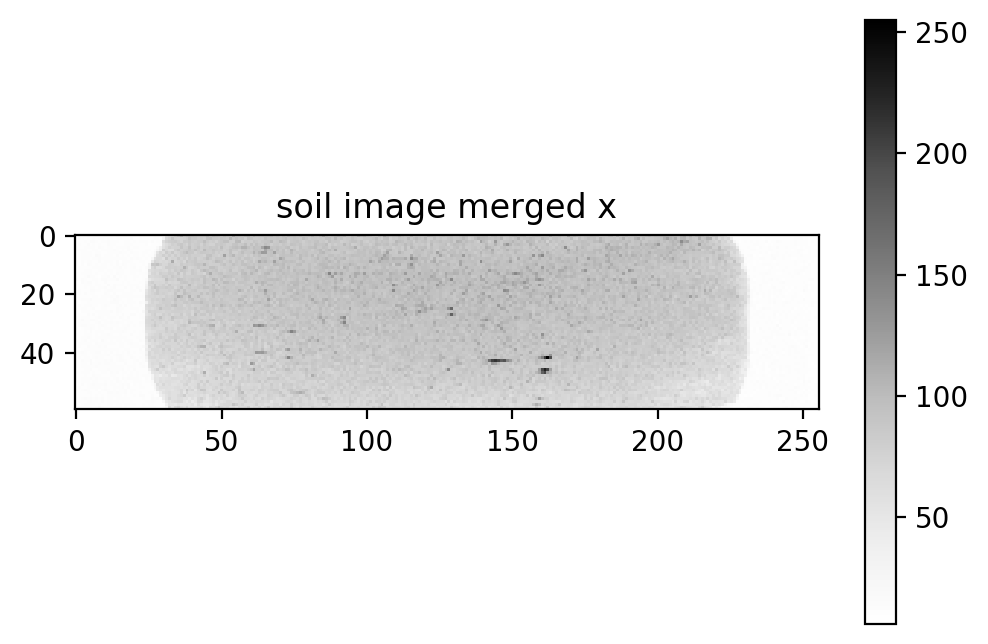

In [40]:
plot_merged_slices(np.squeeze(soil_img)[5:-5,:,:], 'x', 0, 255, title='soil image merged x')